# Introduction

Welcome! In this notebook, we explore the application of **Multi-Agent Reinforcement Learning** (MARL) to model strategic interactions in a ***Stackelberg Competition*** setting. This project integrates concepts from economics, game theory, and reinforcement learning to simulate how firms (agents) learn optimal strategies in a competitive market.

## Overview

In traditional Stackelberg Competition models, firms engage in a leader-follower dynamic:

- Leader Firm: Moves first by choosing its production quantity.
- Follower Firm: Observes the leader's action and responds accordingly.

The conventional objective for both firms is to **maximize immediate profit**. However, real-world firms often consider long-term financial health rather than focusing solely on short-term gains.

## Enhanced Stackelberg Game: Optimize Financial Valuation

Inspired from "Multi-agent Hierarchical Reinforcement Learning with Dynamic Termination", I am introducing a discount factor into the agents' reward functions:

1. Firm/Agent-Objective: Maximize Financial Valuation
2. Discount Factor: The primary heuristic by which agents determine what quantity (q) to produce



## MARL Simulation Mechanism

- Quantity Choice: Each agent-firm decides quantity to produce of a non-differentiable good
- Pricing Function: A function that determines price based on the total goods produced in the market
- Profit Signal: Agent-firms are able to directly calculate their profits and use that as a directional signal of whether to increase or decrease quantity
- Valuation Computation: **Discounted Future Cash-Flows** is the heuristic we will use to allow agents to calculate what their valuation will look like at time *t* based on what their profits will look like at time *t+1*

## Key Features

1. Heuristic-Based Valuation: Simplifies complex future predictions by using a practical estimation method for valuation

2. Dynamic Leader-Follower Interaction: Captures the strategic decision-making process inherent in the Stackelberg model

3. Reinforcement Learning Agents: Both leader and follower are modeled as RL agents that learn optimal strategies over time

## Project Objectives

1. **Demonstrate Advanced ML Techniques**: Show proficiency in applying MARL to economic models with hierarchical structures

2. Explore Long-Term Strategic Planning: Analyze how considering future profits influences agents' strategies compared to short-term profit maximization

3. Bridge Economics and AI: Illustrate the synergy between economic theory and machine learning methodologies

## Pourquoi c'est Important (Why this is Important)

For recruiters and engineers:
- Innovative Application of Machine Learning: Highlights my ability to extend standard models (AI and Economic) by integrating concepts from different domains

- Technical Proficiency: Demonstrates my expertise in Reinforcement Learning, Game Theory, and Adversarial Learning

- Real-World Relevance: Provides insight into how firms might behave when focusing on long-term valuation, a critical consideration in business strategy

## How to Use This Notebook

- Sections: The notebook is organized into clear sections:

  1. Environment Setup: Defines the Stackelberg competition environment with valuation-based rewards.
  2. Agent Implementation: Details the RL algorithms used for the leader and follower agents.
  3. Training Process: Shows how agents learn and adapt their strategies over time.
  4. Results Analysis: Provides visualizations and interpretations of the agents' behaviors and outcomes.

- Interactive Exploration:
  1. Adjust Parameters: Experiment with different discount factors, learning rates, and other hyperparameters.
  2. Observe Behaviors: Rerun simulations to see how changes impact the agents' strategies.
  3. Visualizations: Utilize graphs and charts to gain insights into the learning dynamics.


## Importing Requisite Libraries

In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, TransformedDistribution, SigmoidTransform, AffineTransform
import numpy as np
import random

# Environment Setup

Environment is based on [Gymansium](https://github.com/Farama-Foundation/Gymnasium)

In [ ]:
class StackelbergCompetitionEnv(gym.Env):
    """
    Custom Environment for Stackelberg Competition between two firms.
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, leader_cost, follower_cost, discount_rate=0.9,
                 max_steps=10, max_quantity=100, max_price=1000, demand_factor=5.0):
      super(StackelbergCompetitionEnv, self).__init__()

      # Discount factor for measuring future rewards
      self.discount_rate = discount_rate
      # Max steps allowed PER agent
      self.max_steps = max_steps

      # Leader states
      self.leader_total_valuation = 0.0
      self.leader_quantities = []
      self.leader_cost = leader_cost

      # Follower states
      self.follower_total_valuation = 0.0
      self.follower_quantities = []
      self.follower_cost = follower_cost

      # Pricing factors
      self.max_price = max_price
      self.demand_sensitivity = demand_factor

      # Action space: Each firm chooses a quantity between 0 and a maximum value
      self.max_quantity = max_quantity
      self.action_space = spaces.Box(low=0.0, high=self.max_quantity,
                                      shape=(1,), dtype=np.float32)

      # Observation space: Leader's quantity is observed by the follower
      # Additional state variables can be added if needed
      self.observation_space = spaces.Box(low=0.0, high=self.max_quantity,
                                          shape=(1,), dtype=np.float32)

      # Internal step state
      self.current_step = 0

      # Initialize random seed
      self.seed()


    def seed(self, seed=None):
      np.random.seed(seed)

    def reset(self, seed=None, options=None):
      """
      Reset the environment to an initial state.
      """
      super().reset(seed=seed)
      # Reset the internal state
      self.reset_internal_state()
      # Return initial observation
      observation = np.array([0.0], dtype=np.float32)
      info = {'agent': 'leader'}
      return observation, info

    def reset_internal_state(self):
      self.leader_total_valuation = 0.0
      self.leader_quantities = []
      self.follower_total_valuation = 0.0
      self.follower_quantities = []
      self.current_step = 0

    def step(self, action):
      """
      Execute one time step within the environment.
      """
      terminated = False
      truncated = False
      info = {}

      # Leader goes every other step, starting at step 0
      if self.current_step % 2 == 0:
        leader_quantity = np.clip(action[0], 0.0, self.max_quantity)
        self.leader_quantities.append(leader_quantity)
        # Observation for follower: leader's quantity
        observation = np.array(leader_quantity, dtype=np.float32)
        reward = 0.0  # Leader waits for the follower's move
        info['agent'] = 'leader'
        self.current_step += 1
        return observation, reward, terminated, truncated, info
      else:
        # Follower's turn
        follower_quantity = np.clip(action[0], 0.0, self.max_quantity)
        self.follower_quantities.append(follower_quantity)
        info['agent'] = 'follower'

        # Compute profits and their discounts per step number
        leader_profit, follower_profit = self.calculate_profits()
        discount_leader_profit = leader_profit / ((1 + self.discount_rate) ** self.current_step)
        discount_follower_profit = follower_profit / ((1 + self.discount_rate) ** self.current_step)

        # Add profits to total valuation
        self.leader_total_valuation += (self.discount_rate ** self.current_step) * discount_leader_profit
        self.follower_total_valuation += (self.discount_rate ** self.current_step) * discount_follower_profit

        # Prepare observations (i.e. next state)
        if len(self.follower_quantities) >= 2:
          observation = np.array(self.follower_quantities[-2], dtype=np.float32)
        else:
          observation = np.array([0.0], dtype=np.float32)

        # Follower waits for leader's next move
        reward = 0.0
        # Increment step
        self.current_step += 1

        # Check if episode should terminate
        if self.current_step >= self.max_steps * 2:
          terminated = True
          # Rewards are the final valuations
          reward = np.array([self.leader_total_valuation,
                             self.follower_total_valuation], dtype=np.float32)
        else:
          terminated = False

        return observation, reward, terminated, truncated, info

    def pricing_function(self, q_leader, q_follower):
      """
      Custom Linear pricing function based on combined quantities.
      Example: Inverse demand function P = max_price - a * (Q_leader + Q_follower)
      """
      total_quantity = q_leader + q_follower
      price = self.max_price - self.demand_sensitivity * total_quantity
      price = max(price, 0.0)  # Price cannot be negative
      return price

    def total_cost(self, q, agent):
      """
      Custom cost functions to calculate total cost for both agents to produce
      a given quantity.
      Without this, there is no incentive for the leader NOT to produce
      quantity_max.
      """
      if agent == 'leader':
        return self.leader_cost(q)
      elif agent == 'follower':
        return self.follower_cost(q)
      else:
        raise ValueError("Invalid agent type. Expected 'leader' or 'follower'.")

    def calculate_profits(self):
      """
      Calculate the profits for both firms at the current time step.
      """
      q_leader = self.leader_quantities[-1]
      q_follower = self.follower_quantities[-1]
      # Calculate market price
      price = self.pricing_function(q_leader, q_follower)
      # Calculate total costs
      cost_leader = self.total_cost(q_leader, 'leader')
      cost_follower = self.total_cost(q_follower, 'follower')

      # Calculate revenues
      leader_revenue = q_leader * price
      follower_revenue = q_follower * price

      # Calculate profits
      leader_profit = leader_revenue - cost_leader
      follower_profit = follower_revenue - cost_follower

      return leader_profit, follower_profit

    def render(self):
        pass

    def close(self):
        pass

# Agent Implementation


## Leader Agent

Leader agent model to choose action distributions (based on normal distribution)

In [ ]:
class LeaderAgent(nn.Module):
  def __init__(self, state_size, action_size):
    super(LeaderAgent, self).__init__()
    self.state_size = state_size
    self.action_size = action_size

    # self.fc1 = nn.Linear(state_size, 16)
    # self.fc2 = nn.Linear(16, 16)
    self.fc = nn.Sequential(
        nn.Linear(state_size, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU()
    )
    self.fc_mean = nn.Linear(16, action_size)
    self.fc_std = nn.Linear(16, action_size)

  def forward(self, state):
    # x = F.relu(self.fc1(state))
    # x = F.relu(self.fc2(x))
    x = self.fc(state)
    mean = self.fc_mean(x)
    log_std = torch.exp(self.fc_std(x)) + 1e-6
    return mean, log_std


Leader Agent cost function

In [ ]:
def leader_cost(quantity):
  return 0.01 * quantity ** 2

## Follower Agent

Follower agent model to choose action distributions (based on normal distribution)

In [ ]:
class FollowerAgent(nn.Module):
  def __init__(self, state_size, action_size):
    super(FollowerAgent, self).__init__()
    self.state_size = state_size
    self.action_size = action_size

    # self.fc1 = nn.Linear(state_size, 16)
    self.fc = nn.Sequential(
        nn.Linear(state_size, 16),
        nn.ReLU(),
        nn.Linear(16, 16),
        nn.ReLU()
    )
    # self.fc2 = nn.Linear(16, 16)
    self.fc_mean = nn.Linear(16, action_size)
    self.fc_std = nn.Linear(16, action_size)

  def forward(self, state):
    # x = F.relu(self.fc1(state))
    # x = F.relu(self.fc2(x))
    x = self.fc(state)
    mean = self.fc_mean(x)
    log_std = torch.exp(self.fc_std(x)) + 1e-6
    return mean, log_std


Follower Agent cost function

In [ ]:
def follower_cost(quantity):
  return 0.01 * quantity ** 2

## Action Selection Method

Method selects a quantity (action) for the agent to produce.

I simulate a degree of uncertainty via the standard-deviation estimated by the firm-agent's model itself. I then sample from a **Normal Distribution** what the action/quantity should be given the observed state (other agent's prior time step quantity). I also acquire the log probability of this action for model updates

In [ ]:
# def select_action(agent, state, max_quantity):
#   state = torch.FloatTensor(state).unsqueeze(0)
#   # Process what the mean & std-dev for action-quantity should look like
#   mean, std = agent(state)
#   # Sample new quantity from a normal distribution
#   dist = torch.distributions.Normal(mean, std)
#   action = dist.sample()
#   # Ensure action-quantity is within bounds
#   action = torch.clamp(action, 0.0, max_quantity)
#   log_prob = dist.log_prob(action, require)
#   return action.item(), log_prob

In [ ]:
def select_action(agent, state, max_quantity):
  state = torch.FloatTensor(state).unsqueeze(0).detach()
  # Process what the mean & std-dev for action-quantity should look like
  mean, std = agent(state)
  # Define base distribution
  base_dist = Normal(mean, std)
  # Define transformations to map actions to [0, max_quantity]
  transforms = [SigmoidTransform(), AffineTransform(loc=0.0, scale=max_quantity)]
  # Create the transformed distribution
  dist = TransformedDistribution(base_dist, transforms)
  # Sample action using rsample for reparameterization
  action = dist.rsample()
  # Compute log probability for action
  log_prob = dist.log_prob(action)
  return action, log_prob

# Training/Simulation Process

In [ ]:
# Training hyper parameters
learning_rate = 0.001
num_episodes = 100
discount_rate = 0.05
max_steps = 10
max_quantity = 100
max_price = 1000
demand_price_sensitivity = 5.0

In [ ]:
# Initialization
# environment
env = StackelbergCompetitionEnv(leader_cost, follower_cost,
                                discount_rate=discount_rate, max_steps=max_steps,
                                max_quantity=max_quantity, max_price=max_price,
                                demand_factor=demand_price_sensitivity)

# agents
leader_agent = LeaderAgent(state_size=1, action_size=1)
follower_agent = FollowerAgent(state_size=1, action_size=1)

# agent optimizers
leader_optimizer = optim.Adam(leader_agent.parameters(), lr=learning_rate)
follower_optimizer = optim.Adam(follower_agent.parameters(), lr=learning_rate)

In [ ]:
# Lists to store rewards and log_probs for normalization
leader_total_rewards = []
follower_total_rewards = []
# leader_log_prob_sums = []
# follower_log_prob_sums = []
leader_losses = []
follower_losses = []
torch.autograd.set_detect_anomaly(True)
for episode in range(num_episodes):
  # Reset environment
  state, info = env.reset()
  terminated = False

  # Initialize cumulative log probabilities
  leader_log_prob = []
  follower_log_prob = []
  leader_rewards = []
  follower_rewards = []
  # ct = 0
  while not terminated:
    if info['agent'] == 'leader':
      # Leader's turn
      action, log_prob = select_action(leader_agent, state, max_quantity)
      next_state, reward, terminated, truncated, info = env.step(action.detach().numpy())

      # Accumulate log probability
      leader_log_prob.append(log_prob)
      leader_rewards.append(0.0)


      state = next_state
    else:
      # Follower's turn
      action, log_prob = select_action(follower_agent, state, max_quantity)
      next_state, reward, terminated, truncated, info = env.step(action.detach().numpy())

      # Accumulate log probability
      follower_log_prob.append(log_prob)
      follower_rewards.append(0.0)
      state = next_state

  # Calculate total rewards
  leader_total_reward = reward[0]
  leader_total_rewards.append(leader_total_reward)
  follower_total_reward = reward[1]
  follower_total_rewards.append(follower_total_reward)

  # Assign final rewards to the last time step
  leader_rewards[-1] = leader_total_reward
  follower_rewards[-1] = follower_total_reward

  # Convert lists to tensors
  leader_log_probs = torch.stack(leader_log_prob)
  follower_log_probs = torch.stack(follower_log_prob)
  leader_rewards = torch.tensor(leader_rewards, dtype=torch.float32)
  follower_rewards = torch.tensor(follower_rewards, dtype=torch.float32)

  # Compute losses without reward normalization
  leader_loss = - (leader_log_probs * leader_rewards).sum()
  leader_losses.append(leader_loss.item())
  follower_loss = - (follower_log_probs * follower_rewards).sum()
  follower_losses.append(follower_loss.item())

  # Update leader agent
  leader_optimizer.zero_grad()
  leader_loss.backward()
  leader_optimizer.step()

  # Update follower agent
  follower_optimizer.zero_grad()
  follower_loss.backward()
  follower_optimizer.step()

  # leader_log_prob_sum = torch.cat(leader_log_prob).sum()
  # follower_log_prob_sum = torch.cat(follower_log_prob).sum()
  # ---- Trying stable based backprop for valuation ----
  # After episode ends, retrieve the total valuations as the final reward
  # leader_total_reward = reward[0]
  # follower_total_reward = reward[1]
  # # and store total rewards
  # leader_total_rewards.append(leader_total_reward)
  # follower_total_rewards.append(follower_total_reward)
  # # Convert log probs of leader and follower into computable tensors
  # leader_log_prob_sum = torch.cat(leader_log_prob).sum()
  # follower_log_prob_sum = torch.cat(follower_log_prob).sum()
  # leader_log_prob_sums.append(leader_log_prob_sum)
  # follower_log_prob_sums.append(follower_log_prob_sum)

  # # Update policies every N episodes
  # if (episode + 1) % 10 == 0:
  #   # Normalize rewards
  #   # leader_total_rewards = torch.FloatTensor(leader_total_rewards)
  #   # follower_total_rewards = torch.FloatTensor(follower_total_rewards)
  #   # leader_log_prob_sums = torch.FloatTensor(leader_log_prob_sums)
  #   # follower_log_prob_sums = torch.FloatTensor(follower_log_prob_sums)
  #   leader_mean = torch.mean(torch.FloatTensor(leader_total_rewards))
  #   leader_std = torch.std(torch.FloatTensor(leader_total_rewards)) + 1e-9
  #   follower_mean = torch.mean(torch.FloatTensor(follower_total_rewards))
  #   follower_std = torch.std(torch.FloatTensor(follower_total_rewards)) + 1e-9

  #   leader_rewards_norm = (torch.FloatTensor(leader_total_rewards) - leader_mean) / leader_std
  #   follower_rewards_norm = (torch.FloatTensor(follower_total_rewards) - follower_mean) / follower_std

  #   # Update policies
  #   # Leader update
  #   # print(leader_log_prob_sums)
  #   # print(leader_rewards_norm)
  #   # leader_loss = -leader_log_prob_sums * leader_rewards_norm
  #   # leader_optimizer.zero_grad()
  #   # leader_loss.backward()
  #   # leader_optimizer.step()

  #   # # Follower update
  #   # follower_loss = -follower_log_prob_sums * follower_rewards_norm
  #   # follower_optimizer.zero_grad()
  #   # follower_loss.backward()
  #   # follower_optimizer.step()
  #   for i in range(len(leader_rewards_norm)):
  #     # Leader update
  #     leader_loss = -leader_log_prob_sums[i] * leader_rewards_norm[i]
  #     leader_optimizer.zero_grad()
  #     leader_loss.backward()
  #     leader_optimizer.step()

  #     # Follower update
  #     follower_loss = -follower_log_prob_sums[i] * follower_rewards_norm[i]
  #     follower_optimizer.zero_grad()
  #     follower_loss.backward()
  #     follower_optimizer.step()

    # Clear stored values
    # leader_total_rewards = []
    # follower_total_rewards = []
    # leader_log_prob_sums = []
    # follower_log_prob_sums = []


  # print(leader_total_reward)
  # print(follower_total_reward)
  print(f"Episode {episode+1}/{num_episodes}, Leader Valuation: {leader_total_reward[0]:.4f}, Follower Valuation: {follower_total_reward[0]:.4f}")


<ipython-input-159-a380ea8d1fa4>:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  leader_rewards = torch.tensor(leader_rewards, dtype=torch.float32)
<ipython-input-159-a380ea8d1fa4>:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  follower_rewards = torch.tensor(follower_rewards, dtype=torch.float32)


Episode 1/100, Leader Valuation: 913.9763, Follower Valuation: 962.0297
Episode 2/100, Leader Valuation: 2160.8560, Follower Valuation: 33.5350
Episode 3/100, Leader Valuation: 1762.3820, Follower Valuation: 139.6999
Episode 4/100, Leader Valuation: 1814.6584, Follower Valuation: 106.7909
Episode 5/100, Leader Valuation: 814.5700, Follower Valuation: 547.0342
Episode 6/100, Leader Valuation: 1941.3546, Follower Valuation: 65.7887
Episode 7/100, Leader Valuation: 2269.3762, Follower Valuation: 12.7940
Episode 8/100, Leader Valuation: 1838.1178, Follower Valuation: 80.5664
Episode 9/100, Leader Valuation: 2027.3582, Follower Valuation: 37.8778
Episode 10/100, Leader Valuation: 1917.8408, Follower Valuation: 52.8909
Episode 11/100, Leader Valuation: 1764.3845, Follower Valuation: 80.3182
Episode 12/100, Leader Valuation: 1342.3423, Follower Valuation: 229.0804
Episode 13/100, Leader Valuation: 422.0162, Follower Valuation: 1411.8494
Episode 14/100, Leader Valuation: 2220.4451, Follower Va

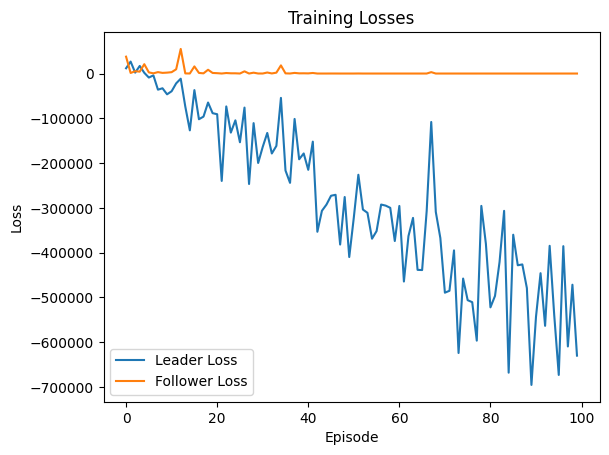

In [ ]:
plt.plot(leader_losses, label='Leader Loss')
plt.plot(follower_losses, label='Follower Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.show()

# Results & Analysis